In [238]:
# Python packages to manipulate files
import os
import pathlib
from pathlib import Path
import datetime
# Tensorflow and Numpy packages
import tensorflow as tf
import numpy as np

# Display related packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import PIL
import PIL.Image

%matplotlib inline

## uncompress the image dataset.

In [239]:
!tar xvzf /root/arabic_handwritten_data.tgz

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
data/train_data/id_8608_label_12.png
data/train_data/id_2106_label_12.png
data/train_data/id_10590_label_8.png
data/train_data/id_2818_label_17.png
data/train_data/id_7349_label_23.png
data/train_data/id_5289_label_18.png
data/train_data/id_3050_label_18.png
data/train_data/id_11114_label_18.png
data/train_data/id_192_label_24.png
data/train_data/id_6258_label_27.png
data/train_data/id_6579_label_11.png
data/train_data/id_9058_label_13.png
data/train_data/id_10945_label_25.png
data/train_data/id_8889_label_20.png
data/train_data/id_4557_label_10.png
data/train_data/id_5785_label_24.png
data/train_data/id_5074_label_19.png
data/train_data/id_7812_label_25.png
data/train_data/id_12978_label_27.png
data/train_data/id_325_label_13.png
data/train_data/id_9146_label_24.png
data/train_data/id_5488_label_14.png
data/train_data/id_7108_label_21.png
data/train_data/id_9379_label_25.png
data/train_data/id_3045_label_17.

In [240]:
logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# **Check available compute capabilities**
### If you have a GPU uncomment the last line to check that your Tensorflow installation supports GPU


In [241]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
tf.config.set_visible_devices([], 'GPU')

# **MLP I**

In [304]:
batch_size = 8
img_height = 32
img_width = 32

def get_dataset(dataset_dir):
    
    def process_filename(file_path):
        label = tf.strings.regex_replace(input=file_path,pattern=r".+_label_(\d+)\.png", rewrite=r"\1")
        label = tf.strings.to_number(label, tf.int32)
        #label = tf.one_hot(label, depth=29)
        return label

    def process_img(file_path):

        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, size=(32, 32))
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255.0
        #img = tf.image.rgb_to_grayscale(img)
        #img = tf.image.convert_image_dtype(img, tf.float32)
        #img = tf.image.resize(img, size=(32, 32))
        return img
    
    data_dir = pathlib.Path(dataset_dir)
    file_list = [str(path.absolute()) for path in Path(data_dir).glob("*.png")]
    files_ds = tf.data.Dataset.from_tensor_slices((file_list))
    files_ds = files_ds.map(lambda x: (process_img(x), process_filename(x)))
    return files_ds

In [305]:
train_dataset_path = "data/train/train_data"
test_dataset_path = "data/test/test_data"

train_ds = get_dataset(train_dataset_path).shuffle(buffer_size=batch_size*10).batch(batch_size)
valid_ds = get_dataset(test_dataset_path).batch(batch_size)

In [292]:
model = tf.keras.Sequential([
    # Convert the 28x28 image into a flat vector of 28x28 = 784 values
    tf.keras.layers.Flatten(input_shape=(32, 32, 3), name='flatten_input'),
    # Create a "hidden" layer with 256 neurons and apply the ReLU non-linearity
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name='input_to_hidden1'),
    # Create another hidden layer with 128 neurons
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1_to_hidden2'),
    # Create an "output layer" with 10 neurons
    tf.keras.layers.Dense(29, name='hidden_to_logits'),
])

In [293]:
model.summary()

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (Flatten)      (None, 3072)              0         
_________________________________________________________________
input_to_hidden1 (Dense)     (None, 256)               786688    
_________________________________________________________________
hidden1_to_hidden2 (Dense)   (None, 128)               32896     
_________________________________________________________________
hidden_to_logits (Dense)     (None, 29)                3741      
Total params: 823,325
Trainable params: 823,325
Non-trainable params: 0
_________________________________________________________________


In [246]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [247]:
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-2,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=2,
#         verbose=1,
#     )
# ]
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir=logdir,
        histogram_freq=0,  # How often to log histogram visualizations
        embeddings_freq=0,  # How often to log embedding visualizations
        update_freq="epoch",
    ) 
]

In [248]:
print("Fit model on training data")
history = model.fit(train_ds, epochs = 50, validation_data=valid_ds, callbacks = callbacks)


Fit model on training data
Epoch 1/50
420/420 [==============================] - 14s 33ms/step - loss: 1.8559 - sparse_categorical_accuracy: 0.4305 - val_loss: 1.2313 - val_sparse_categorical_accuracy: 0.5914
Epoch 2/50
420/420 [==============================] - 14s 34ms/step - loss: 0.9616 - sparse_categorical_accuracy: 0.6854 - val_loss: 0.9581 - val_sparse_categorical_accuracy: 0.6795
Epoch 3/50
420/420 [==============================] - 14s 33ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7887 - val_loss: 0.8905 - val_sparse_categorical_accuracy: 0.7158
Epoch 4/50
420/420 [==============================] - 14s 33ms/step - loss: 0.4480 - sparse_categorical_accuracy: 0.8484 - val_loss: 0.8452 - val_sparse_categorical_accuracy: 0.7494
Epoch 5/50
420/420 [==============================] - 14s 33ms/step - loss: 0.3212 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.8457 - val_sparse_categorical_accuracy: 0.7533
Epoch 6/50
420/420 [==============================] - 14s 33ms/

# CNN with data augmentation

In [302]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(
        '/content/data/train',
        target_size=(32, 32),
        batch_size=8,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/data/test',
        target_size=(32, 32),
        batch_size=8,
        class_mode='binary')

model2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model2.summary()

model2.compile(optimizer='RMSprop', loss='binary_crossentropy', 
              metrics=['accuracy']) 

# this throws value error
history = model2.fit(
  train_generator,
  steps_per_epoch=30,
  epochs=25,
  validation_data=validation_generator,
  validation_steps=5,
)

Found 13440 images belonging to 1 classes.
Found 3360 images belonging to 2 classes.
Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_364 (Conv2D)          (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_319 (MaxPoolin (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_365 (Conv2D)          (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_320 (MaxPoolin (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_366 (Conv2D)          (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_321 (MaxPoolin (None, 2, 2, 64)          0         
_________________________________

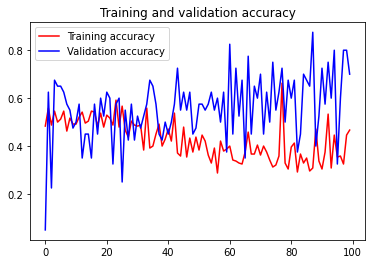

<Figure size 432x288 with 0 Axes>

In [253]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# CNN without data augmentation

In [306]:
model3 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 32x32 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(29, activation='softmax')
])

model3.summary()

model3.compile(
    optimizer=tf.keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# this throws value error
history = model3.fit(
  train_ds,
  steps_per_epoch=30,
  epochs=25,
  validation_data=valid_ds,
  validation_steps=30,
)

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_370 (Conv2D)          (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_325 (MaxPoolin (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_371 (Conv2D)          (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_326 (MaxPoolin (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_372 (Conv2D)          (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_327 (MaxPoolin (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_118 (Flatten)        (None, 256)            

In [149]:
Comparer les resultats obtenus avec ou sans augmentation ainsi que par rapport aux resultats obtenus par le MLP

In [310]:
model.evaluate(train_ds, test_ds)

ValueError: ignored

In [308]:
model.evaluate(train_ds, test_ds)

In [308]:
model.evaluate(train_ds, test_ds)